In [246]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import imutils
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from random import shuffle
!pip3 install torchsummary
from torchsummary import summary
import torch.nn.init as init
import math

In [247]:
!nvidia-smi

Thu Sep 24 08:47:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    42W / 300W |  16109MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [248]:
%cd /content/drive/My Drive/veria

/content/drive/My Drive/veria


In [249]:
"""import os

os.system("unrar x Covid19.rar")
"""

'import os\n\nos.system("unrar x Covid19.rar")\n'

In [250]:
!ls

Covid19  Covid19.rar


In [251]:
%cd Covid19

/content/drive/My Drive/veria/Covid19


In [252]:
%cd Covid

/content/drive/My Drive/veria/Covid19/Covid


In [253]:
!pwd

/content/drive/My Drive/veria/Covid19/Covid


In [254]:
!ls

0.png	  1244.png  1489.png  1732.png	1977.png  26.png   513.png  758.png
1000.png  1245.png  148.png   1733.png	1978.png  270.png  514.png  759.png
1001.png  1246.png  1490.png  1734.png	1979.png  271.png  515.png  75.png
1002.png  1247.png  1491.png  1735.png	197.png   272.png  516.png  760.png
1003.png  1248.png  1492.png  1736.png	1980.png  273.png  517.png  761.png
1004.png  1249.png  1493.png  1737.png	1981.png  274.png  518.png  762.png
1005.png  124.png   1494.png  1738.png	1982.png  275.png  519.png  763.png
1006.png  1250.png  1495.png  1739.png	1983.png  276.png  51.png   764.png
1007.png  1251.png  1496.png  173.png	1984.png  277.png  520.png  765.png
1008.png  1252.png  1497.png  1740.png	1985.png  278.png  521.png  766.png
1009.png  1253.png  1498.png  1741.png	1986.png  279.png  522.png  767.png
100.png   1254.png  1499.png  1742.png	1987.png  27.png   523.png  768.png
1010.png  1255.png  149.png   1743.png	1988.png  280.png  524.png  769.png
1011.png  1256.png  14.png   

In [255]:
path = !pwd

In [256]:
path = path[0]

In [257]:
test = Image.open(path + "/1.png")

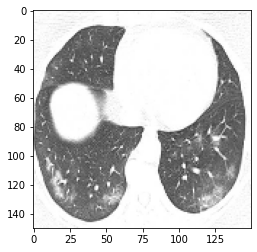

In [258]:
plt.imshow(test)

In [259]:
%cd ..
!ls

path = !pwd
path = path[0]
covid_data_path = path + "/Covid"
healthy_data_path = path + "/Healthy"
others_data_path = path + "/Others"

/content/drive/My Drive/veria/Covid19
Covid  Healthy	Others


In [260]:
covid_data = [torch.tensor(np.array(Image.open(covid_data_path+"/"+img)), dtype = torch.float32).view(3,150,150) for img in os.listdir(covid_data_path)]

In [261]:
print(covid_data[0].shape)
print(len(covid_data))

torch.Size([3, 150, 150])
2167


In [262]:
healthy_data =[torch.tensor(np.array(Image.open(healthy_data_path+"/"+img)), dtype = torch.float32).view(3,150,150) for img in os.listdir(healthy_data_path)]

In [263]:
print(healthy_data[0].shape)
print(len(healthy_data))

torch.Size([3, 150, 150])
757


In [264]:
others_data =[torch.tensor(np.array(Image.open(others_data_path+"/"+img)), dtype = torch.float32).view(3,150,150) for img in os.listdir(others_data_path)]

In [265]:
print(others_data[0].shape)
print(len(others_data))

torch.Size([3, 150, 150])
1247


In [266]:
shuffle(covid_data)

In [267]:
shuffle(healthy_data)

In [268]:
shuffle(others_data)

In [269]:
covid_data = torch.stack(covid_data) / 255
healthy_data = torch.stack(healthy_data) / 255
others_data = torch.stack(others_data) / 255

In [270]:
covid = []
healthy = []
others = []

for i in covid_data:
  covid.append(tuple((i, 0)))

for i in healthy_data:
  healthy.append(tuple((i, 1)))

for i in others_data:
  others.append(tuple((i, 2)))

In [271]:
train_covid = covid[0:1500]

In [272]:
val_covid = covid[1500:2167]

In [273]:
print(len(train_covid), len(val_covid))

1500 667


In [274]:
train_healthy = healthy[0:500]

In [275]:
val_healthy = healthy[500:757]

In [276]:
print(len(train_healthy), len(val_healthy))

500 257


In [277]:
train_others = others[0:900]

In [278]:
val_others = others[900:1247]

In [279]:
print(len(train_others), len(val_others))

900 347


In [280]:
train = []
train += train_covid
train += train_healthy
train += train_others

In [281]:
len(train)

2900

In [282]:
val = []
val += val_covid
val += val_healthy
val += val_others

In [283]:
shuffle(train)
shuffle(val)

In [284]:
train_data_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

In [285]:
val_data_loader = torch.utils.data.DataLoader(val, batch_size=128, shuffle=True)

In [294]:
class demirnet(nn.Module):
    
    def __init__(self):
        
        super(demirnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size= 3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size= 3)

        self.batch1 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size= 3)

        self.batch2 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size= 3)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size= 3)

        self.batch3 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size= 3)

        self.batch4 = nn.BatchNorm2d(1024)

        self.conv7 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size= 3)

        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv8 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size= 3)

        self.batch5 = nn.BatchNorm2d(256)

        self.conv9 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size= 3)
        
        self.batch6 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(12800, 6000)
        self.fc2 = nn.Linear(6000, 1000)
        self.drop = nn.Dropout(p =float(0.5), inplace=bool(False))
        self.fc3 = nn.Linear(1000, 3)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.batch1(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.batch2(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.maxpool2(x)
        x = F.leaky_relu(self.conv5(x))
        x = self.batch3(x)
        x = F.leaky_relu(self.conv6(x))
        x = self.batch4(x)
        x = F.leaky_relu(self.conv7(x))
        x = self.maxpool3(x)
        x = F.leaky_relu(self.conv8(x))
        x = self.batch5(x)
        x = F.leaky_relu(self.conv9(x))
        x = self.batch6(x)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.drop(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

    def __conv__(self):

        return [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.conv6, self.conv7, self.conv8, self.conv9]

In [295]:
model = demirnet()
device = torch.device("cuda")
model=model.to(device) 

In [296]:
def gain(a):
    return math.sqrt(2.0 / (1 + a**2))

def kaiming_uniform(x, a):
    n = x[0].shape.numel()
    std = gain(a) / math.sqrt(n)
    bound = math.sqrt(3.) * std
    x.data.uniform_(-bound, bound)

for l in model.__conv__():
  print("a")
  kaiming_uniform(l.weight, a = 0)
  l.bias.data.zero_()

a
a
a
a
a
a
a
a
a


In [297]:
print(model)

print("Model = ",next(model.parameters()).device," da eğitilecek")

demirnet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))


In [298]:
loss_func = nn.CrossEntropyLoss()

opt = optim.Adam(model.parameters(), lr=1e-4)

In [299]:
def metrics_batch(target, output):
    pred = output.argmax(dim=1, keepdim=True)
    
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [300]:
def loss_batch(loss_func, xb, yb,yb_h, opt=None):
    
    loss = loss_func(yb_h, yb)
    
    metric_b = metrics_batch(yb,yb_h)
    
    if opt is not None:
        loss.backward() 
        opt.step() 
        opt.zero_grad() 

    return loss.item(), metric_b

In [301]:
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    loss=0.0
    metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.type(torch.float).to(device)
        yb=yb.to(device)
        
        yb_h=model(xb)

        loss_b,metric_b=loss_batch(loss_func, xb, yb,yb_h, opt)
        loss+=loss_b
        if metric_b is not None:
            metric+=metric_b
            
    loss/=len_data 
    metric/=len_data
    return loss, metric

In [302]:
def train_val(epochs, model, loss_func, opt, train_dl, val_dl):

  top_train_loss = []
  top_val_loss = []
  top_train_metric = []
  top_val_metric = []
    
  for epoch in range(epochs):
      
    model.train()
    train_loss, train_metric=loss_epoch(model,loss_func,train_dl,opt)
    top_train_loss.append(train_loss)
    top_train_metric.append(train_metric)
            
    model.eval()
    with torch.no_grad():
      val_loss, val_metric=loss_epoch(model,loss_func,val_dl)
      top_val_loss.append(val_loss)
      top_val_metric.append(val_metric)

      print("epoch: %d, train loss: %.6f, val loss: %.6f, train accuracy: %.6f, val accuracy: %.6f" %(epoch, train_loss, val_loss, train_metric, val_metric))

  return top_train_loss, top_val_loss, top_train_metric, top_val_metric

# Training with our init

In [303]:
num_epochs=15
top_train_loss, top_val_loss, top_train_metric, top_val_metric = train_val(num_epochs, model, loss_func, opt, train_data_loader, val_data_loader)

epoch: 0, train loss: 0.006640, val loss: 0.010087, train accuracy: 0.598621, val accuracy: 0.535799
epoch: 1, train loss: 0.003979, val loss: 0.009250, train accuracy: 0.789310, val accuracy: 0.578285
epoch: 2, train loss: 0.001702, val loss: 0.006415, train accuracy: 0.917931, val accuracy: 0.693155
epoch: 3, train loss: 0.000781, val loss: 0.005196, train accuracy: 0.971724, val accuracy: 0.773407
epoch: 4, train loss: 0.001204, val loss: 0.007770, train accuracy: 0.945172, val accuracy: 0.708891
epoch: 5, train loss: 0.000809, val loss: 0.004901, train accuracy: 0.963103, val accuracy: 0.780488
epoch: 6, train loss: 0.000629, val loss: 0.005059, train accuracy: 0.973448, val accuracy: 0.817467
epoch: 7, train loss: 0.000552, val loss: 0.005827, train accuracy: 0.974138, val accuracy: 0.778127
epoch: 8, train loss: 0.000279, val loss: 0.005384, train accuracy: 0.987586, val accuracy: 0.816680
epoch: 9, train loss: 0.000204, val loss: 0.005577, train accuracy: 0.990000, val accuracy:

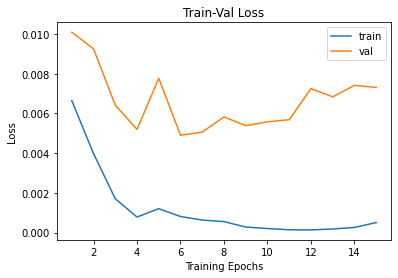

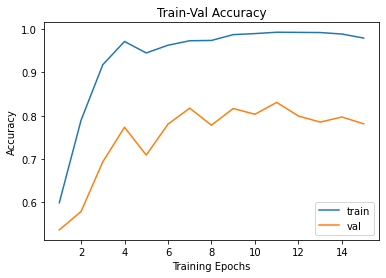

In [304]:
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),top_train_loss,label="train")
plt.plot(range(1,num_epochs+1),top_val_loss,label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),top_train_metric,label="train")
plt.plot(range(1,num_epochs+1),top_val_metric,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()